<a href="https://colab.research.google.com/github/JasonManesis/Ship-Classification-in-Satellite-Images/blob/main/Ship_Classification_in_Satellite_Images_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Loading and Preprocessing

In [28]:
#Import necessary libraries.
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from matplotlib.image import imread
import cv2
import json
import sklearn as skl
from sklearn.model_selection import train_test_split 

In [2]:
#Connect with your personal Google Drive.
import google.colab
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Load .json data file.
f = open(r'/content/drive/MyDrive/Projects/Python_Projects/Ship_Classification_in_Satellite_Images_Keras/shipsnet.json')
dataset = json.load(f)
f.close()
print('The above dataset is in "{}" type'.format(type(dataset)))

The above dataset is in "<class 'dict'>" type


In [23]:
locations = pd.DataFrame(dataset['locations'], columns=["λ","φ"])
locations.head()

,λ,φ
0,-118.225469,33.738037
1,-122.332229,37.749176
2,-118.142831,33.736016
3,-122.347843,37.766487
4,-122.348524,37.758785


In [22]:
scene_ids = pd.DataFrame(dataset['scene_ids'], columns=[" Scene ID"])
scene_ids.head(5)

,Scene ID
0,20180708_180909_0f47
1,20170705_180816_103e
2,20180712_211331_0f06
3,20170609_180756_103a
4,20170515_180653_1007


In [5]:
input_data = np.array(dataset['data']).astype('uint8')
input_targets = np.array(dataset['labels']).astype('uint8')

In [6]:
#Create a 3d data tensor with the red channels of all input images.
stack = np.zeros(shape=(80,80))
for image in range(0,input_data.shape[0]): 
  newimage = input_data[image,:].reshape(3,80,80)[0]
  stack = np.dstack((stack,newimage))
X_data = stack[:,:,1:]

In [7]:
#Change the shape of the data tensor from (80,80,4000) to (4000,80,80)
X_data_2 = np.zeros(shape=(input_data.shape[0],80,80))
for i in range(0,input_data.shape[0]): 
  X_data_2[i,:,:] = X_data[:,:,i]
X = X_data_2
print("Created data tensor has size of {} x {} x {} voxels.".format(X.shape[0],X.shape[1],X.shape[2]))

Created data tensor has size of 4000 x 80 x 80 voxels.


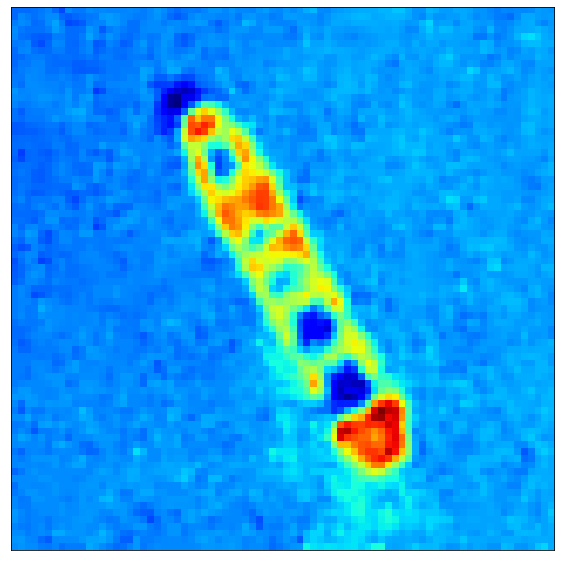

In [9]:
#Show the x-st image from the 3d data tensor X.
f = plt.figure(figsize=(10,10))

#Turn off x and y labels.
frame1 = plt.gca()
frame1.axes.get_xaxis().set_visible(False)
frame1.axes.get_yaxis().set_visible(False)

#Show the 556th image.
plt.imshow(X[555,:,:], cmap='jet');

In [11]:
#Normalize the data in the interval [0,1].
maxval = np.amax(X)
X = X/maxval
if np.amax(X)<=1: print("Data tensor normalized successfully")

Data tensor normalized successfully


In [12]:
y = input_targets
if X.shape[0]==y.shape[0]: print('Train and test tensors are in correct shape')
#Convert catecory numbers to categorical variables because the model will assume that they are continious numbers.
y = tf.keras.utils.to_categorical(y)

Train and test tensors are in correct shape


In [13]:
#Split the data to train and test sets.
indices = np.arange(4000)
X_train, X_test, y_train, y_test, train_idxs, test_idxs= train_test_split( X, y, indices, test_size=0.33, random_state=42)

In [14]:
#Reshape the data tensors into 4 dimensional tensors (Images x width x height x number of channels)
X_train = np.expand_dims(X_train, axis=3)
X_test = np.expand_dims(X_test, axis=3)

In [15]:
#Check train and test tensors.
if len(X_train.shape)==len(X_test.shape) and len(X_test.shape)==4: print("Train end test tensors are in correct shape")

Train end test tensors are in correct shape


#Build and train the model.

In [16]:
#Build the model.
from tensorflow.keras.layers import Dense, Conv2D, Input, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

i = Input(shape=X_train[0].shape)
x = Conv2D(filters=32, kernel_size=(3,3), strides=(1, 1), padding='valid', activation='relu')(i)
x = Conv2D(filters=64, kernel_size=(3,3), strides=(1, 1), padding='valid', activation='relu')(x)
x = Conv2D(filters=128, kernel_size=(3,3), strides=(1, 1), padding='valid', activation='relu')(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dense(2, activation='softmax')(x)

model = Model(i,x)

In [17]:
#Compile the model and fit it in the train data.
model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=["accuracy"])
earlystopping = EarlyStopping(monitor='val_loss', patience=3)
y_train2=y_train[:,1]
r = model.fit(x=X_train, y=y_train2, batch_size=None, epochs=15, verbose=1, callbacks=[earlystopping], validation_split=0.05)

Epoch 1/15
80/80 [==============================] - 40s 118ms/step - loss: 3.5285 - accuracy: 0.7546 - val_loss: 0.1782 - val_accuracy: 0.9478
Epoch 2/15
80/80 [==============================] - 9s 107ms/step - loss: 0.1990 - accuracy: 0.9231 - val_loss: 0.1978 - val_accuracy: 0.9478
Epoch 3/15
80/80 [==============================] - 9s 107ms/step - loss: 0.1524 - accuracy: 0.9433 - val_loss: 0.2521 - val_accuracy: 0.9030
Epoch 4/15
80/80 [==============================] - 9s 107ms/step - loss: 0.2386 - accuracy: 0.9094 - val_loss: 0.1930 - val_accuracy: 0.9552


In [21]:
#Save the final model, once training is completed.
model_name = '/content/drive/My Drive/Projects/Python_Projects/CNN/Ship_Detection_CNN.h5'
model.save(model_name)

#Model Evaluation.

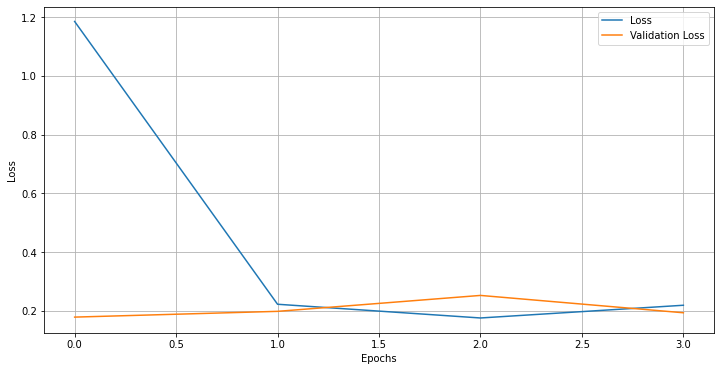

In [18]:
#Plot loss for both train and validation data.
plt.figure(figsize=(12,6))
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(r.history['loss'], label="Loss")

plt.plot(r.history['val_loss'], label="Validation Loss")
plt.legend();

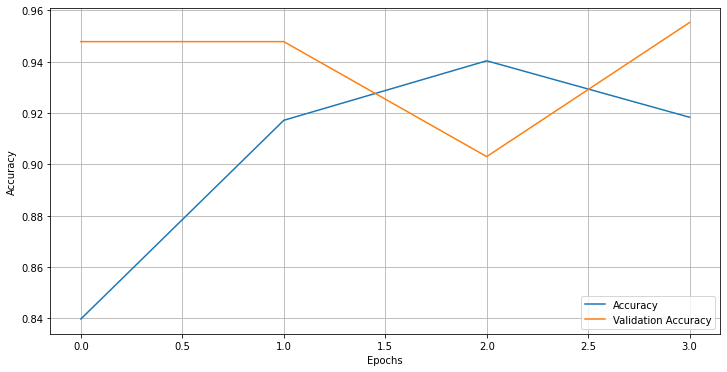

In [19]:
#Plot accuracy for both train and validation data.
plt.figure(figsize=(12,6))
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(r.history['accuracy'], label="Accuracy")
plt.plot(r.history['val_accuracy'], label="Validation Accuracy")
plt.legend();

In [24]:
#Load the model and make predictions.
model = tf.keras.models.load_model('/content/drive/My Drive/Projects/Python_Projects/CNN/Ship_Detection_CNN.h5')

In [20]:
#Threshold the predicted results.
ypred = model.predict(X_test)
ypred = ypred > 0.5

In [24]:
#Make a dataframe with image ids, true and predicted values, scene ids, and ship center points.
y_all = np.concatenate((y_test[:,1].reshape(-1,1), ypred[:,1].reshape(-1,1)), axis=1)
df = pd.DataFrame(y_all, columns=["True Label","Predicted Label"], index=test_idxs)
df = df.sort_index()
df["Scene id"] = scene_ids.loc[test_idxs].sort_index()
df["Image center longitude"] = locations["λ"].loc[test_idxs].sort_index()
df["Image center latitude"] = locations["φ"].loc[test_idxs].sort_index()
df.to_csv("/content/drive/My Drive/Projects/Python_Projects/CNN/y_locations_and_scenes.csv")

In [29]:
#Print the classification report.
print(skl.metrics.classification_report(y_true=y_test[:,1], y_pred=ypred[:,1]))

              precision    recall  f1-score   support

         0.0       0.96      0.90      0.93       970
         1.0       0.77      0.91      0.84       350

    accuracy                           0.91      1320
   macro avg       0.87      0.91      0.88      1320
weighted avg       0.91      0.91      0.91      1320



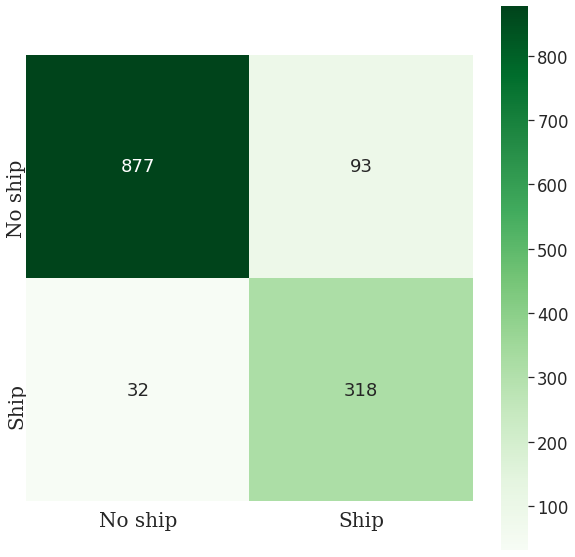

In [35]:
plt.figure(figsize=(10,10))
sns.set(font_scale=1.5)
sns.heatmap(skl.metrics.confusion_matrix(y_true=df["True Label"], y_pred=df['Predicted Label']), annot=True, square=True, fmt='g', cmap="Greens")
plt.yticks(ticks=[0.5,1.5], labels=["No ship","Ship"], size=20, family="serif", ha="center")
plt.xticks(ticks=[0.5,1.5], labels=["No ship","Ship"], size=20, family="serif", ha ="center");

#Detected ships visualization





In [30]:
#Read saved .csv.
detected_ships_df = pd.read_csv('/content/drive/MyDrive/Projects/Python_Projects/Ship_Classification_in_Satellite_Images_Keras/y_locations_and_scenes.csv', index_col=0)

In [31]:
#Find correctly classified ships.
detected_ships_df = detected_ships_df.loc[(detected_ships_df['True Label']==detected_ships_df['Predicted Label']) & (detected_ships_df['True Label']==1)]

In [32]:
#Show the first 5 ships from the new dataframe.
detected_ships_df.head()

,True Label,Predicted Label,Scene id,Image center longitude,Image center latitude
0,1.0,1.0,20180708_180909_0f47,-118.225469,33.738037
7,1.0,1.0,20170508_180611_1010,-122.351587,37.747364
8,1.0,1.0,20170703_180945_1009,-122.346954,37.739848
12,1.0,1.0,20170723_180812_1005,-122.325792,37.726750
14,1.0,1.0,20180708_182358_1032,-122.346815,37.759451


In [33]:
#Select ramdomly 20 correct classified ships.
random_ships = np.random.choice(detected_ships_df.index, size=20)

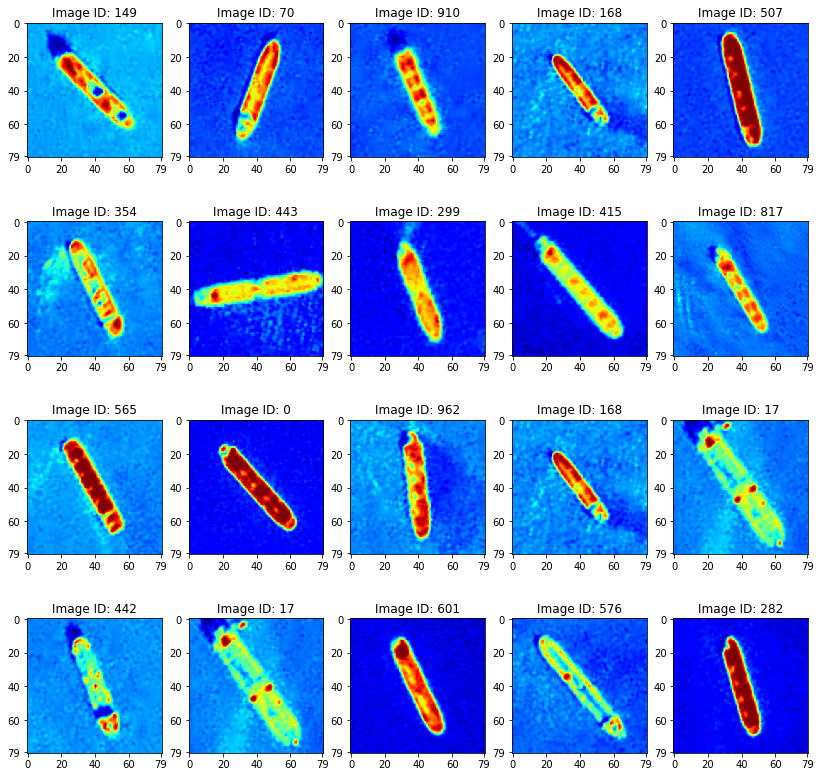

In [34]:
#Plot 20 correct classified ships. (true positives)
w=10
h=10
fig=plt.figure(figsize=(14, 14))
columns = 5
rows = 4
tickpos = [0,20,40,60,79]
for i in range(1, columns*rows +1):
    img = X[random_ships[i-1],:,:]
    fig.add_subplot(rows, columns, i)
    plt.title("Image ID: {}".format(random_ships[i-1]))
    plt.imshow(img, cmap="jet")
    plt.xticks(ticks=tickpos)
    plt.yticks(ticks=tickpos)
plt.show()